# Extract SST Patterns from Precursor Regions

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN

import netCDF4

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os

DATA_ROOT = os.path.abspath("../../data")

In [2]:
def plot_earth(view="EARTH"):
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [25, 10]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.OCEAN, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    if view == "US":
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
    elif view == "EAST US":
        ax.set_xlim(-105, -65)
        ax.set_ylim(25, 50)
    elif view == "EARTH":
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    
    return projection

### Load Precursor Data from Disk

In [3]:
# Load Raw Data From Disk
PRECURSOR_PATH = os.path.join(DATA_ROOT, 'sem/2019-01-21.npy')
PRECURSOR_DATA = np.load(PRECURSOR_PATH, encoding='latin1').item()['ex']['score_per_run']

# Precursor Regions Dimensions
PRECURSOR_LONGITIUDE = PRECURSOR_DATA[0][3].longitude.values
PRECURSOR_LATITUDE = PRECURSOR_DATA[0][3].latitude.values
PRECURSOR_LAGS = PRECURSOR_DATA[0][3].lag.values
PRECURSOR_YEARS = np.array([data[0][0] for data in PRECURSOR_DATA])

# Precursor Grid (to calculate precursor region centre coordinate)
PRECURSOR_GRID = np.zeros((len(PRECURSOR_LATITUDE), len(PRECURSOR_LONGITIUDE), 2))
PRECURSOR_GRID[..., 0], PRECURSOR_GRID[..., 1] = np.meshgrid(PRECURSOR_LONGITIUDE, PRECURSOR_LATITUDE)

# Array Containing Precursor Region Indices for each YEAR and LAG
precursor_indices = np.zeros((len(PRECURSOR_YEARS),
                              len(PRECURSOR_LAGS),
                              len(PRECURSOR_LATITUDE),
                              len(PRECURSOR_LONGITIUDE)),
                             np.uint8)

precursor_coordinates = []

# Array Containing Precursor Region Weights for each YEAR and LAG
precursor_weights = np.zeros_like(precursor_indices, np.float32)

# Fill Indices and Weight Arrays with Precursor Data
for year_idx, (year, _, _, pattern, _) in enumerate(PRECURSOR_DATA):
    for lag_idx, (lag, indices, weights) in enumerate([(l.values, i.values, w.values) for (l, i, w) in zip(pattern.lag, pattern.pattern_num, pattern.weights)]):
        
        for region_idx in np.unique(indices[~np.isnan(indices)]):
            
            # Fill Precursor Indices Array
            precursor_indices[year_idx, lag_idx, indices == region_idx] = int(region_idx)
            
            # Fill Precursor Coordinates Dictionary with Region Centre Coordinates
            precursor_coordinates.append(([year_idx, lag_idx, int(region_idx)], PRECURSOR_GRID[indices == region_idx].mean(0)))
            
        # Fill Weights Array
        precursor_weights[year_idx, lag_idx] = weights
        

# Group Similar Precursor Regions Together
precursor_coordinates_index = np.array([index for index, coord in precursor_coordinates])
precursor_coordinates_coord = np.array([coord for index, coord in precursor_coordinates])

precursor_coordinates_group = DBSCAN(eps=10).fit_predict(precursor_coordinates_coord) + 2

precursor_indices_new = np.zeros_like(precursor_indices)

for (year_idx, lag_idx, region_idx), group in zip(precursor_coordinates_index, precursor_coordinates_group):
    precursor_indices_new[year_idx, lag_idx, precursor_indices[year_idx, lag_idx] == region_idx] = group
    
precursor_indices = precursor_indices_new

print(np.unique(precursor_coordinates_group))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


### Load Sea Surface Temperature (SST) Data from Disk & Calculate SST Anomaly Data

In [4]:
# Load Sea Surface Temperatures (SST)
SST = netCDF4.Dataset(os.path.join(DATA_ROOT, 'ERA/sst_1979-2017_1_12_daily_2.5deg.nc'))
SST_LONGITUDE, SST_LATITUDE = SST['longitude'][:].data, SST['latitude'][:]

# Contstrain SST Region to Pattern Region
SST_LATITUDE_INDEX = np.where(SST_LATITUDE == PRECURSOR_LATITUDE[0])[0][0]
SST_LATITUDE = SST_LATITUDE[SST_LATITUDE_INDEX:SST_LATITUDE_INDEX+len(PRECURSOR_LATITUDE)]

# Get SST DateTime Information & Load (Bounded) SST Data
TIME = pd.DataFrame(data=np.arange(len(SST['time'][:])),
                    index=pd.to_datetime(SST['time'][:], unit='h', origin="1900-01-01"))

# Calculate SST Anomalies
SST_anomaly = SST['sst'][:, SST_LATITUDE_INDEX:SST_LATITUDE_INDEX+len(PRECURSOR_LATITUDE), :]
SST_df = pd.DataFrame(SST_anomaly[SST_anomaly > 0].reshape(len(TIME), -1), index=TIME.index)
SST_df_anomaly = SST_df.groupby([SST_df.index.month, SST_df.index.day]).apply(lambda x: x - x.mean())
SST_anomaly[SST_anomaly > 0] = SST_df_anomaly.values.ravel()

### Plot Data

In [7]:
precursor_indices.shape

(39, 4, 37, 144)

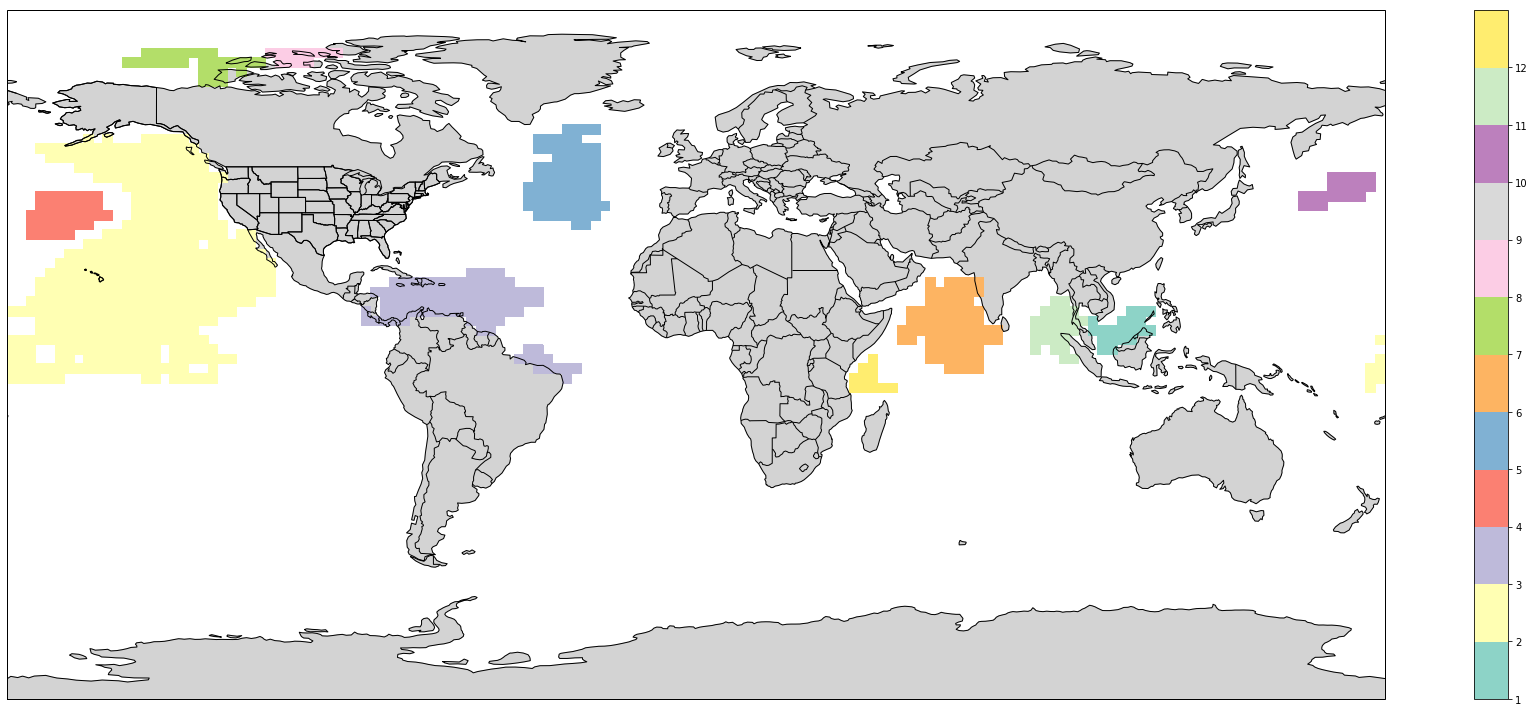

In [42]:
PRECURSOR_PLOT_LAG = 0

precursor_plot = precursor_indices[:, PRECURSOR_PLOT_LAG, :, :].max(0).astype(np.float32)
precursor_plot[precursor_plot == 0] = np.NaN

plot_earth()
plt.pcolormesh(PRECURSOR_LONGITIUDE, PRECURSOR_LATITUDE, precursor_plot, cmap='Set3', vmin=1, vmax=13)
# plt.title(f"Combined Precursor Regions (lag = {PRECURSOR_PLOT_LAG})")
plt.colorbar().set_ticks(range(1, 13))
plt.tight_layout()
plt.savefig('precursor_regions.png', dpi=300)
plt.show()

### Load Heatwave Timeseries from Disk

In [5]:
heatwave = pd.read_csv(os.path.join(DATA_ROOT, 'out/heatwave.csv'), names=["date", "series"])
heatwave["date"] = pd.DatetimeIndex(heatwave["date"])
heatwave = heatwave.set_index("date")
heatwave_threshold = (heatwave.mean() + heatwave.std())[0]

### Calculate Spatial Covariance between Heatwave & SST Anomaly Data
1. Calculate Weighted Composite of SST Anomalies @ Heatwave Events
2. Calculate Weighted Spatial Covariance between Composite & SST Anomalies

In [7]:
VECTOR_LENGTH = len(PRECURSOR_LATITUDE) * len(PRECURSOR_LONGITIUDE)

SST_anomaly_ravel = SST_anomaly.reshape((len(TIME), VECTOR_LENGTH))
precursor_indices_ravel = precursor_indices.reshape(len(PRECURSOR_YEARS), len(PRECURSOR_LAGS), VECTOR_LENGTH)
precursor_weights_ravel = precursor_weights.reshape(len(PRECURSOR_YEARS), len(PRECURSOR_LAGS), VECTOR_LENGTH)
cos_weights_ravel = np.cos(np.deg2rad(PRECURSOR_LATITUDE)).repeat(len(PRECURSOR_LONGITIUDE))


# Loop Trough Test Years and Lags
for year_idx, year in enumerate(PRECURSOR_YEARS):
    for lag_idx, lag in enumerate(PRECURSOR_LAGS):
        print(f"\rProcessing {year}", end="")
        
        # Create DataFrame to store TimeSeries
        df = pd.DataFrame(index=TIME.index)
        df.index.name = "date"
        
        # Select Heatwave Events from all years, except this test year
        heatwave_series = heatwave[heatwave.index.year != year]
        
        # Select Sea Surface Temperature Anomalies at 'lag' days before Heatwave Events
        sst_at_heatwave = SST_anomaly_ravel[TIME.loc[heatwave_series.index - pd.Timedelta(lag, 'D')].values.ravel()]
        
        # Loop through Precursor Regions
        for region_idx in np.unique(precursor_indices_ravel[year_idx, lag_idx])[1:]:
            region = precursor_indices_ravel[year_idx, lag_idx] == region_idx
            
            # Get SST Anomalies within Region
            sst = SST_anomaly_ravel[:, region]
            
            # Calculate Weights for this Region
            # Weights are a normalised multiplication of:
            #  1. Precursor Weights   resulting from Region Certainty/Robustness
            #  2. Cosine Weights      resulting from Region Latitudes (and a spherical Earth)
            weights = precursor_weights_ravel[year_idx, lag_idx, region] * cos_weights_ravel[region]
            weights /= np.sum(weights)
            
            sst_sa = np.average(sst, axis=1, weights=weights)
            sst_std = np.average(np.sqrt((sst_sa.reshape(-1, 1) - sst)**2), axis=1, weights=weights)
            
            df[f"{region_idx}-average"] = sst_sa
            
            # Calculate Sea Surface Temperature Anomaly Composite at Region
            # Composite is Calculated by averaging SST Anomalies over time, weighted by Heatwave Strength (T95)
            composite = np.average(sst_at_heatwave[:, region], axis=0, weights=heatwave_series.values.ravel() > heatwave_threshold)
            
            # Calculate Weighted Spatial Covariance 
            covariance = np.sum((composite - composite.mean()) * (sst - sst.mean(1, keepdims=True)) * weights, 1) / float(len(weights) - 1)
            
            # Store Normalized Covariance in DataFrame
            df[f"{region_idx}-covariance"] = covariance
        
        df.to_csv(os.path.join(DATA_ROOT, f'patterns/{year}-{lag}.csv'))

Processing 2017